Class Distribution:
diagnosis
1    1852
0    1796
Name: count, dtype: int64


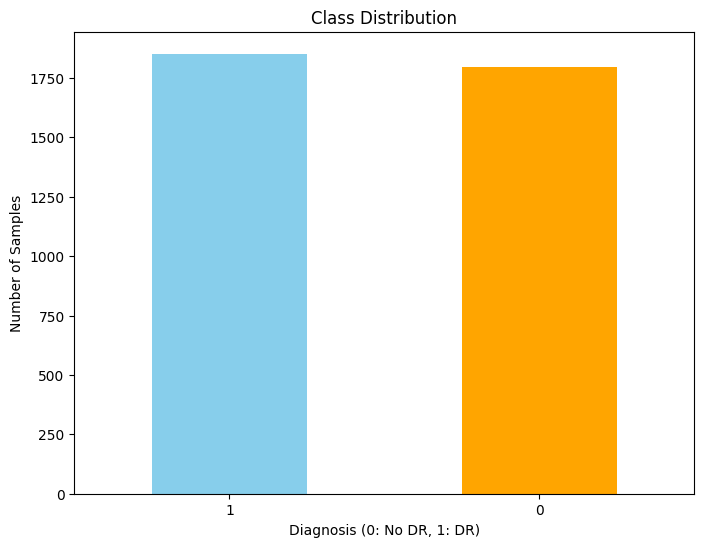

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
cleaned_csv_path = r"D:\APTOS data\fyp_processed_dataset\cleaned_image_labels.csv"
data = pd.read_csv(cleaned_csv_path)

# Class distribution
class_counts = data['diagnosis'].value_counts()
print("Class Distribution:")
print(class_counts)

# Visualize the distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution")
plt.xlabel("Diagnosis (0: No DR, 1: DR)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()


As classes are balanced, no sampling will be done.

In [15]:
import os
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Paths
original_csv_path = r"D:\APTOS data\fyp_processed_dataset\cleaned_image_labels.csv"
image_folder = r"D:\APTOS data\fyp_processed_dataset\images"
augmented_folder = r"D:\APTOS data\fyp_processed_dataset\augmented_images"
os.makedirs(augmented_folder, exist_ok=True)

# Load the original dataset
data = pd.read_csv(original_csv_path)

# Inspect the data
print("Original Dataset:")
print(data.head())
print(f"Total original images: {data.shape[0]}")


Original Dataset:
        id_code  diagnosis                                         image_path
0  000c1434d8d7          1  D:\APTOS data\fyp_processed_dataset\images\000...
1  001639a390f0          1  D:\APTOS data\fyp_processed_dataset\images\001...
2  0024cdab0c1e          1  D:\APTOS data\fyp_processed_dataset\images\002...
3  002c21358ce6          0  D:\APTOS data\fyp_processed_dataset\images\002...
4  005b95c28852          0  D:\APTOS data\fyp_processed_dataset\images\005...
Total original images: 21886


In [16]:
def pad_and_resize(img, target_size=(224, 224)):
    h, w, _ = img.shape
    scale = target_size[0] / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)

    # Resize the image while maintaining aspect ratio
    resized = cv2.resize(img, (new_w, new_h))

    # Add padding to reach target size
    top = (target_size[0] - new_h) // 2
    bottom = target_size[0] - new_h - top
    left = (target_size[1] - new_w) // 2
    right = target_size[1] - new_w - left

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded


In [17]:
# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=30,          # Rotate images randomly up to 30 degrees
    zoom_range=0.2,             # Slight zoom in/out
    horizontal_flip=True,       # Flip images horizontally
    vertical_flip=False,        # No vertical flip for medical images
    fill_mode='nearest'         # Fill empty areas with nearest pixel values
)

# Number of augmented images per original image
augment_count = 2


In [18]:
print("Generating augmented images...")
for img_name in tqdm(os.listdir(image_folder), desc="Augmenting images"):
    img_path = os.path.join(image_folder, img_name)
    if img_path.endswith(".png"):
        img = cv2.imread(img_path)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = pad_and_resize(img)  # Pad and resize to maintain aspect ratio
        img = img.reshape((1,) + img.shape)  # Reshape for the generator
        
        # Save augmented images
        aug_iter = datagen.flow(img, batch_size=1, save_to_dir=augmented_folder, 
                                save_prefix=f"{os.path.splitext(img_name)[0]}_aug", save_format='png')
        for _ in range(augment_count):
            next(aug_iter)


Generating augmented images...


Augmenting images: 100%|██████████| 3648/3648 [05:25<00:00, 11.22it/s]


In [19]:
# Create new entries for augmented images
augmented_data = []
for img_name in os.listdir(augmented_folder):
    if img_name.endswith(".png"):
        # Extract the original ID from the augmented filename
        original_id = img_name.split("_aug")[0]
        # Find the diagnosis for the original image
        label = data[data['id_code'] == original_id]['diagnosis'].values[0]
        # Append a new entry for the augmented image
        augmented_data.append({"id_code": os.path.splitext(img_name)[0], "diagnosis": label})

# Convert to DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Combine with the original dataset
updated_data = pd.concat([data, augmented_df], ignore_index=True)

# Save the updated dataset
updated_csv_path = r"D:\APTOS data\fyp_processed_dataset\cleaned_image_labels.csv"
updated_data.to_csv(updated_csv_path, index=False)

print(f"Updated dataset saved to: {updated_csv_path}")
print(f"Total images in updated dataset: {updated_data.shape[0]}")


Updated dataset saved to: D:\APTOS data\fyp_processed_dataset\cleaned_image_labels.csv
Total images in updated dataset: 29181


In [20]:
# Verify the dimensions of augmented images
incorrect_dimensions = []
for img_name in os.listdir(augmented_folder):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    if (h, w) != (224, 224):
        incorrect_dimensions.append((img_name, h, w))

if len(incorrect_dimensions) == 0:
    print("All images have correct dimensions (224x224).")
else:
    print(f"{len(incorrect_dimensions)} images have incorrect dimensions:")
    for name, h, w in incorrect_dimensions[:10]:  # Print the first 10
        print(f"{name}: {h}x{w}")


All images have correct dimensions (224x224).


In [21]:
# check if the augmented dataset is valid 
import pandas as pd
import os

# Paths
csv_path = r"D:\APTOS data\fyp_processed_dataset\cleaned_image_labels.csv"
original_images_folder = r"D:\APTOS data\fyp_processed_dataset\images"
augmented_images_folder = r"D:\APTOS data\fyp_processed_dataset\augmented_images"

# Load the dataset
data = pd.read_csv(csv_path)

# Inspect the dataset
print("Dataset loaded:")
print(data.head())


Dataset loaded:
        id_code  diagnosis                                         image_path
0  000c1434d8d7          1  D:\APTOS data\fyp_processed_dataset\images\000...
1  001639a390f0          1  D:\APTOS data\fyp_processed_dataset\images\001...
2  0024cdab0c1e          1  D:\APTOS data\fyp_processed_dataset\images\002...
3  002c21358ce6          0  D:\APTOS data\fyp_processed_dataset\images\002...
4  005b95c28852          0  D:\APTOS data\fyp_processed_dataset\images\005...


In [22]:
# Get image IDs from the original folder
original_ids = set(os.path.splitext(f)[0] for f in os.listdir(original_images_folder) if f.endswith(".png"))

# Get image IDs from the augmented folder
augmented_ids = set(os.path.splitext(f)[0] for f in os.listdir(augmented_images_folder) if f.endswith(".png"))

# Combine both sets
all_folder_ids = original_ids.union(augmented_ids)


In [23]:
# Get image IDs from the CSV
csv_ids = set(data['id_code'])

# Find missing and extra IDs
missing_in_csv = all_folder_ids - csv_ids
missing_in_folders = csv_ids - all_folder_ids

# Print results
if not missing_in_csv:
    print("All folder IDs are accounted for in the CSV.")
else:
    print(f"IDs missing in CSV: {len(missing_in_csv)}")
    print(list(missing_in_csv)[:10])  # Print first 10 missing IDs for inspection

if not missing_in_folders:
    print("All CSV IDs are accounted for in the folders.")
else:
    print(f"IDs missing in folders: {len(missing_in_folders)}")
    print(list(missing_in_folders)[:10])  # Print first 10 missing IDs for inspection


All folder IDs are accounted for in the CSV.
IDs missing in folders: 18228
['65f5d2a6eb7e_aug_0_90', 'e821c1b6417a_aug_0_6447', '7ddcfcea7369_aug_0_2876', 'febfb20dc311_aug_0_2698', 'ad570b850a4f_aug_0_9375', '85fce24084da_aug_0_1093', '1c578b72d7b3_aug_0_4264', '1509d097b69a_aug_0_2757', 'ae975c43bd8b_aug_0_7219', 'c1437a7a52c9_aug_0_1276']


In [24]:
# Total images in folders and CSV
print(f"Number of images in CSV: {len(csv_ids)}")
print(f"Number of images in folders (combined): {len(all_folder_ids)}")


Number of images in CSV: 29171
Number of images in folders (combined): 10943


In [25]:
import os
import pandas as pd

# Paths
csv_path = r"D:\APTOS data\fyp_processed_dataset\cleaned_image_labels.csv"
original_images_folder = r"D:\APTOS data\fyp_processed_dataset\images"
augmented_images_folder = r"D:\APTOS data\fyp_processed_dataset\augmented_images"

# Get image IDs from the original folder
original_ids = set(os.path.splitext(f)[0] for f in os.listdir(original_images_folder) if f.endswith(".png"))

# Get image IDs from the augmented folder
augmented_ids = set(os.path.splitext(f)[0] for f in os.listdir(augmented_images_folder) if f.endswith(".png"))

# Combine both sets of IDs
all_folder_ids = original_ids.union(augmented_ids)


In [26]:
# Load the CSV file
data = pd.read_csv(csv_path)

# Get IDs from the CSV
csv_ids = set(data['id_code'])

# Find valid IDs (those that exist in the folders)
valid_ids = csv_ids.intersection(all_folder_ids)

# Filter the CSV to keep only rows with valid IDs
filtered_data = data[data['id_code'].isin(valid_ids)]

# Save the cleaned CSV
cleaned_csv_path = r"D:\APTOS data\fyp_processed_dataset\cleaned_valid_image_labels.csv"
filtered_data.to_csv(cleaned_csv_path, index=False)

print(f"Filtered CSV saved to: {cleaned_csv_path}")
print(f"Number of rows in the filtered CSV: {len(filtered_data)}")
` 

Filtered CSV saved to: D:\APTOS data\fyp_processed_dataset\cleaned_valid_image_labels.csv
Number of rows in the filtered CSV: 10949


In [27]:
# IDs in the CSV but not in the folders
extra_ids_in_csv = csv_ids - all_folder_ids

# IDs in the folders but not in the CSV
missing_ids_in_csv = all_folder_ids - csv_ids

# Print results
print(f"Number of extra IDs in CSV: {len(extra_ids_in_csv)}")
print(f"Extra IDs in CSV (first 10): {list(extra_ids_in_csv)[:10]}")

print(f"Number of missing IDs in CSV: {len(missing_ids_in_csv)}")
print(f"Missing IDs in CSV (first 10): {list(missing_ids_in_csv)[:10]}")


Number of extra IDs in CSV: 18228
Extra IDs in CSV (first 10): ['65f5d2a6eb7e_aug_0_90', 'e821c1b6417a_aug_0_6447', '7ddcfcea7369_aug_0_2876', 'febfb20dc311_aug_0_2698', 'ad570b850a4f_aug_0_9375', '85fce24084da_aug_0_1093', '1c578b72d7b3_aug_0_4264', '1509d097b69a_aug_0_2757', 'ae975c43bd8b_aug_0_7219', 'c1437a7a52c9_aug_0_1276']
Number of missing IDs in CSV: 0
Missing IDs in CSV (first 10): []


In [28]:
import os
import pandas as pd

# Paths
csv_path = r"D:\APTOS data\fyp_processed_dataset\cleaned_valid_image_labels.csv"
original_images_folder = r"D:\APTOS data\fyp_processed_dataset\images"
augmented_images_folder = r"D:\APTOS data\fyp_processed_dataset\augmented_images"

# Load the CSV file
data = pd.read_csv(csv_path)

# Get IDs from the CSV
csv_ids = set(data['id_code'])

# Get IDs from the original images folder
original_ids = set(os.path.splitext(f)[0] for f in os.listdir(original_images_folder) if f.endswith(".png"))

# Get IDs from the augmented images folder
augmented_ids = set(os.path.splitext(f)[0] for f in os.listdir(augmented_images_folder) if f.endswith(".png"))

# Combine folder IDs
all_folder_ids = original_ids.union(augmented_ids)

# Check for missing IDs in folders
missing_in_folders = csv_ids - all_folder_ids

# Check for extra IDs in folders
extra_in_folders = all_folder_ids - csv_ids

# Results
if not missing_in_folders:
    print("All images listed in the CSV are present in the folders.")
else:
    print(f"Missing images in folders: {len(missing_in_folders)}")
    print(f"Missing IDs (first 10): {list(missing_in_folders)[:10]}")
    # Save missing IDs to a text file
    with open(r"D:\APTOS data\missing_ids_in_folders.txt", "w") as file:
        file.write("\n".join(missing_in_folders))

if not extra_in_folders:
    print("No extra images are present in the folders.")
else:
    print(f"Extra images in folders: {len(extra_in_folders)}")
    print(f"Extra IDs (first 10): {list(extra_in_folders)[:10]}")
    # Save extra IDs to a text file
    with open(r"D:\APTOS data\extra_ids_in_folders.txt", "w") as file:
        file.write("\n".join(extra_in_folders))

# Final Dataset Check
print(f"Number of images in CSV: {len(csv_ids)}")
print(f"Number of images in folders (combined): {len(all_folder_ids)}")

All images listed in the CSV are present in the folders.
No extra images are present in the folders.
Number of images in CSV: 10943
Number of images in folders (combined): 10943
